## Exercises 🛠

1. Play with neural networks in the [TensorFlow Playground](https://playground.tensorflow.org/) for 10-minutes. Especially try different values of the learning, what happens when you decrease it? What happens when you increase it?
2. Replicate the model pictured in the [TensorFlow Playground diagram](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=6,6,6,6,6&seed=0.51287&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&discretize_hide=true&regularizationRate_hide=true&percTrainData_hide=true&dataset_hide=true&problem_hide=true&noise_hide=true&batchSize_hide=true) below using TensorFlow code. Compile it using the Adam optimizer, binary crossentropy loss and accuracy metric. Once it's compiled check a summary of the model.
![tensorflow playground example neural network](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-replication-exercise.png)
*Try this network out for yourself on the [TensorFlow Playground website](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=6,6,6,6,6&seed=0.51287&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&discretize_hide=true&regularizationRate_hide=true&percTrainData_hide=true&dataset_hide=true&problem_hide=true&noise_hide=true&batchSize_hide=true). Hint: there are 5 hidden layers but the output layer isn't pictured, you'll have to decide what the output layer should be based on the input data.*
3. Create a classification dataset using Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function, visualize it and then build a model to fit it at over 85% accuracy.
4. Create a function (or write code) to visualize multiple image predictions for the fashion MNIST at the same time. Plot at least three different images and their prediciton labels at the same time. Hint: see the [classifcation tutorial in the TensorFlow documentation](https://www.tensorflow.org/tutorials/keras/classification) for ideas.
5. Recreate [TensorFlow's](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) [softmax activation function](https://en.wikipedia.org/wiki/Softmax_function) in your own code. Make sure it can accept a tensor and return that tensor after having the softmax function applied to it.
6. Train a model to get 88%+ accuracy on the fashion MNIST test set. Plot a confusion matrix to see the results after.
7. Make a function to show an image of a certain class of the fashion MNIST dataset and make a prediction on it. For example, plot 3 images of the `T-shirt` class with their predictions.



## [3] Create make_moons dataset and train a classification model

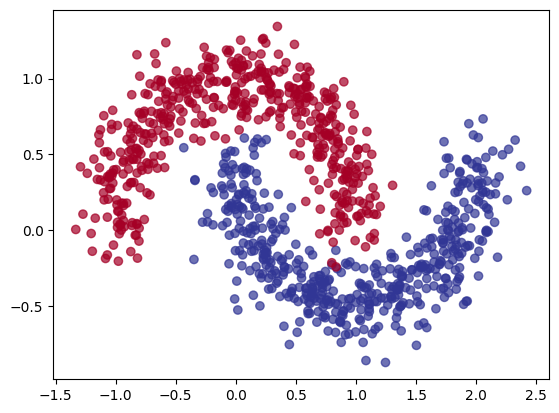

In [11]:
# Create dataset:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
X, y = make_moons(n_samples=1000, noise=0.15, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, alpha=0.7);
# Split data into train and test sets
X_train, y_train = X[:700], y[:700] # 80% of the data for the training set
X_test, y_test = X[700:], y[700:] # 20% of the data for the test set

In [13]:
# Visualize the predictions:

import numpy as np

def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))

  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html

  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)

  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

In [28]:
# Build simple architectures:
import tensorflow as tf

def create_model(
    dense_layers,
    hidden_activ=tf.keras.activations.relu,
    last_activ=tf.keras.activations.sigmoid,
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
    ):
    """
    Creates a ML model using only Dense layers.
    {dense_layers} [List]: each element represents the number of neurons for the input and
    hidden layers, in that order.
    {hidden_activ} [Tensorflow activation function]: activation function for all layers except
    the last one.
    {last_activ} [Tensorflow activation function]: activation function for the last (output) layer.
    {loss} [Tensorflow loss function]: loss function for the model.
    {optimizer} [Tensorflow optimizer]: optimizer for the model.
    {metrics} [List]: Single element list with the desired metric for the model.
    """
    tf.random.set_seed(42) # Set random seed
    
    # Create the input and hidden layers:
    model = tf.keras.Sequential()
    for d in dense_layers:
        model.add(tf.keras.layers.Dense(d, activation=hidden_activ))
    model.add(tf.keras.layers.Dense(1, activation=last_activ))

    # Compile the model:
    model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
    
    return model 

313/313 [==============================] - 0s 732us/step
doing binary classifcation...


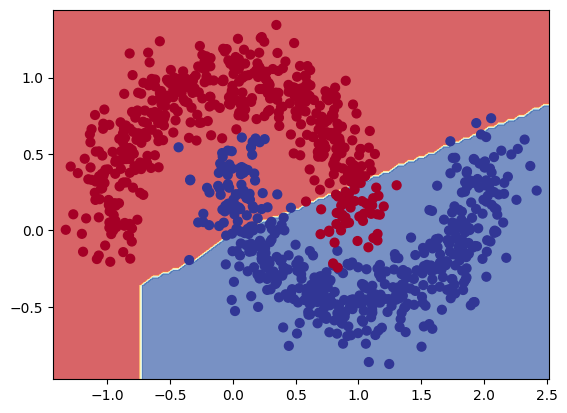

In [31]:
# Create the model:
model_1 = create_model([4,4],
                       hidden_activ=tf.keras.activations.relu,
                       last_activ=tf.keras.activations.sigmoid,
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy']
                       )
# Fit and evaluate:
model_1.fit(X, y, epochs=20, verbose=0) # fit for 100 passes of the data
model_1.evaluate(X,y)
plot_decision_boundary(model_1, X, y)

In [32]:
# Find a good learning rate:

# Prepare callbacks:
total_epochs = 100
lr_scheduler_f = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))
lr_scheduler_r = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**((total_epochs-epoch+1)/20))

class reset_weights(tf.keras.callbacks.Callback):
    def __init__(self, patience=0):
        super().__init__()

    def on_train_begin(self, logs=None):
        self.init_weights = self.model.get_weights()
        
    def on_epoch_end(self, epoch, logs=None):
        self.model.set_weights(self.init_weights)

### Forward training schedule ###

# Create the model:
model_2_f = create_model([4,4],
                       hidden_activ=tf.keras.activations.relu,
                       last_activ=tf.keras.activations.sigmoid,
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy']
                       )
# Train for 1 epoch to set the internal parameters:
model_2_f.fit(X_train,y_train,epochs=1,verbose=0)
# Fit the model using the forward LR schedule and reset_weights:
history_f = model_2_f.fit(X_train,y_train,epochs=total_epochs,
                          callbacks=[lr_scheduler_f,reset_weights()],
                          verbose=0)

### Reverse training schedule ###

# Create the model:
model_2_r = create_model([4,4],
                       hidden_activ=tf.keras.activations.relu,
                       last_activ=tf.keras.activations.sigmoid,
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy']
                       )
# Train for 1 epoch to set the internal parameters:
model_2_r.fit(X_train,y_train,epochs=1,verbose=0)
# Fit the model using the backwards LR schedule and reset_weights:
history_r = model_2_r.fit(X_train,y_train,epochs=total_epochs,
                          callbacks=[lr_scheduler_r,reset_weights()],
                          verbose=0)

### Simple training schedule ###

# Create the model:
model_2_s = create_model([4,4],
                       hidden_activ=tf.keras.activations.relu,
                       last_activ=tf.keras.activations.sigmoid,
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy']
                       )
# Fit the model using the forward LR schedule:
history_s = model_2_s.fit(X_train,y_train,epochs=total_epochs,
                          callbacks=[lr_scheduler_f],
                          verbose=0)

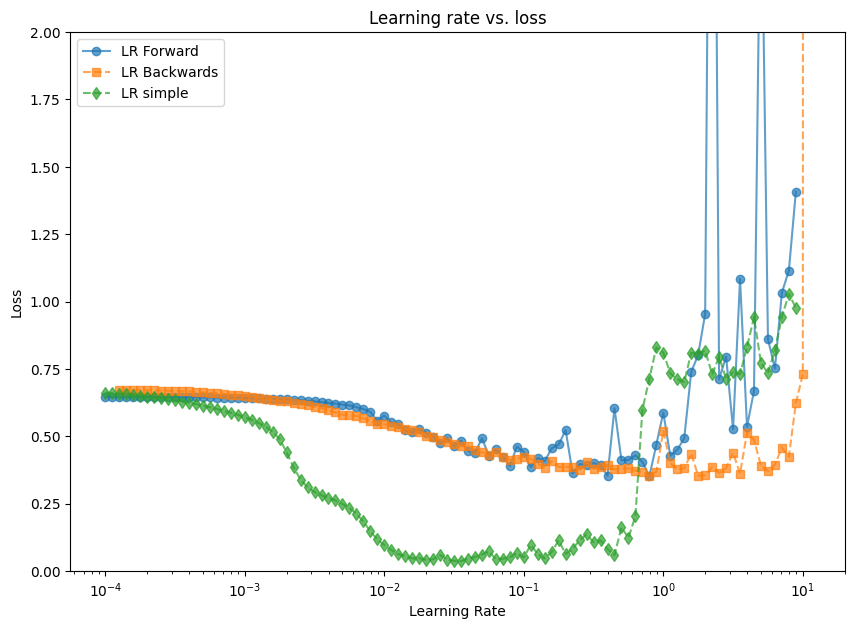

In [33]:
# Plot results:
lrs_f, loss_f = history_f.history["lr"], history_f.history["loss"]
lrs_r, loss_r = history_r.history["lr"], history_r.history["loss"]
lrs_s, loss_s = history_s.history["lr"], history_s.history["loss"]
plt.figure(figsize=(10, 7))
plt.semilogx(lrs_f, loss_f,'o-',label='LR Forward',alpha=0.7)
plt.semilogx(lrs_r, loss_r,'s--',label='LR Backwards',alpha=0.7)
plt.semilogx(lrs_s, loss_s,'d--',label='LR simple',alpha=0.7)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.legend()
plt.ylim([0,2])
plt.title("Learning rate vs. loss");

From the [green] simple LR schedule (just train progressively using different learning rates), the loss has the sharpest negative slope around 0.002 or 0.01.

From the [blue] forward and [orange] backwards LR schedule (every epoch the model's weights are restored to 'Epoch 1'), the loss has the sharpest negative slope between 0.01 and 0.1. 

I'll keep in mind all criteria and play with LR=[0.001-0.1].

313/313 [==============================] - 0s 663us/step
doing binary classifcation...


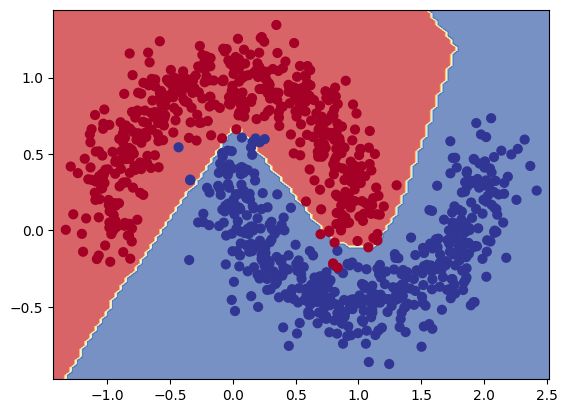

In [58]:
# Train a new model with the chosen LR, for longer:

# Create the model:
model_3 = create_model([4,4],
                       hidden_activ=tf.keras.activations.relu,
                       last_activ=tf.keras.activations.sigmoid,
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), # Between 0.01 and 0.1 works best
                       metrics=['accuracy']
                       )

# Fit and evaluate the model:
history_3 = model_3.fit(X_train, y_train, epochs=30,verbose=0)
model_3.evaluate(X_test,y_test)
plot_decision_boundary(model_3, X, y)

## [4] Plotting fashion MNIST

Create a function (or write code) to visualize multiple image predictions for the fashion MNIST at the same time. Plot at least three different images and their prediciton labels at the same time.

In [45]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# The data has already been sorted into training and test sets for us
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()
# Correlate numeric labels to article classes:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [252]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_examples(data,labels,class_names=None,N=9,unit_size=2,columns=3):
    """
    Visualize image examples from the training dataset along with the ground truth.

    --- Inputs ---
    
    {data} [Numpy]: array containing images, with shape (samples,width,height). Each element
    is a matrix representing an image (sample).
    {labels} [Numpy]: array containing the labels for images, with shape (samples).
    {class_names} [List or None]: if provided, and if {labels} contains integers as labels,
    transform the integer label to the corresponding element in the list.
    {N} [Integer]: number of samples to be randomly plotted.
    {unit_size} [Float]: determines the size for each image display, as a square with
    dimensions {unit_size} x {unit_size}.
    {columns} [Integer]: number of columns in which all images will be organized.

    --- Return ---

    Array of images representing random samples within the provided dataset along with their
    ground truth labels.
    
    """
    # Prepare images and figure layout:
    images = np.random.choice(data.shape[0],size=N,replace='False') # Choose random images
    rows = np.ceil(N/columns).astype(int) # Number of rows
    if N <= columns: # Set number of columns, correct if wrong configuration:
        cols = N
    else:
        cols = columns
    figsize = (cols*unit_size,rows*unit_size)
    # Plot figure:
    fig, axes = plt.subplots(rows,cols,figsize=figsize)
    for i in range(rows*cols):
        row, col = np.ceil((i+1)/cols).astype(int)-1, i % cols # Get current row and column
        if N == 1:
            ax = axes
        elif N <= cols:
            ax = axes[col]
        elif cols == 1:
            ax = axes[row]
        else:
            ax = axes[row][col]
        if i < len(images): # Plots out of range will be blank
            ax.imshow(data[images[i]]) # Plot image in current axis
            label = class_names[labels[images[i]]] if class_names else labels[images[i]] # Get label
            ax.set_title(label)
        ax.axis(False) # Remove XY axes
    fig.tight_layout()

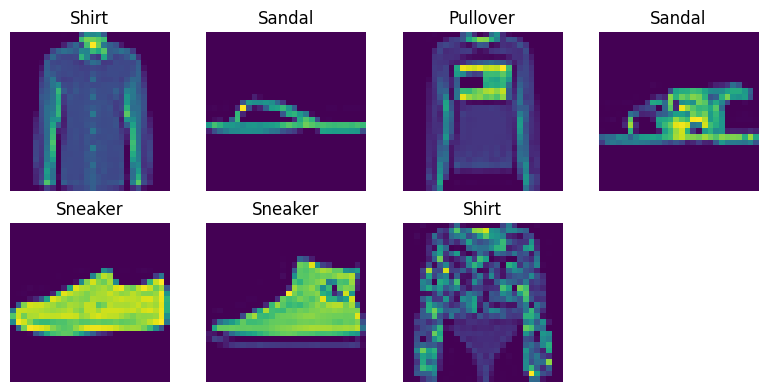

In [249]:
visualize_examples(train_data,train_labels,class_names=class_names,N=7,columns=4,unit_size=2)

In [ ]:
# DEFINE FUNCION TO VISUALIZE EXAMPLES AND PREDICTIONS

## Extra curriculum 📖
* Watch 3Blue1Brown's neural networks video 2: [*Gradient descent, how neural networks learn*](https://www.youtube.com/watch?v=IHZwWFHWa-w). After you're done, write 100 words about what you've learned.
  * If you haven't already, watch video 1: [*But what is a Neural Network?*](https://youtu.be/aircAruvnKk). Note the activation function they talk about at the end.
* Watch [MIT's introduction to deep learning lecture 1](https://youtu.be/njKP3FqW3Sk) (if you haven't already) to get an idea of the concepts behind using linear and non-linear functions.
* Spend 1-hour reading [Michael Nielsen's Neural Networks and Deep Learning book](http://neuralnetworksanddeeplearning.com/index.html).
* Read the [ML-Glossary documentation on activation functions](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html). Which one is your favourite?
  * After you've read the ML-Glossary, see which activation functions are available in TensorFlow by searching "tensorflow activation functions".